[Reference](https://pub.towardsai.net/timesfm-googles-foundational-model-for-time-series-forecasting-adde6782232c)

In [9]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/Branden-Kang/Time-Series-Analysis/master/Data/GoldPrices.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').resample('MS').mean()
df = df.reset_index() # Reset index to have 'Date' as a column again
print(df.head())

        Date  India(INR)
0 2008-12-01     42374.2
1 2009-01-01     44945.2
2 2009-02-01     48685.3
3 2009-03-01     46498.6
4 2009-04-01     44193.4


<ipython-input-9-25fffdb35648>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


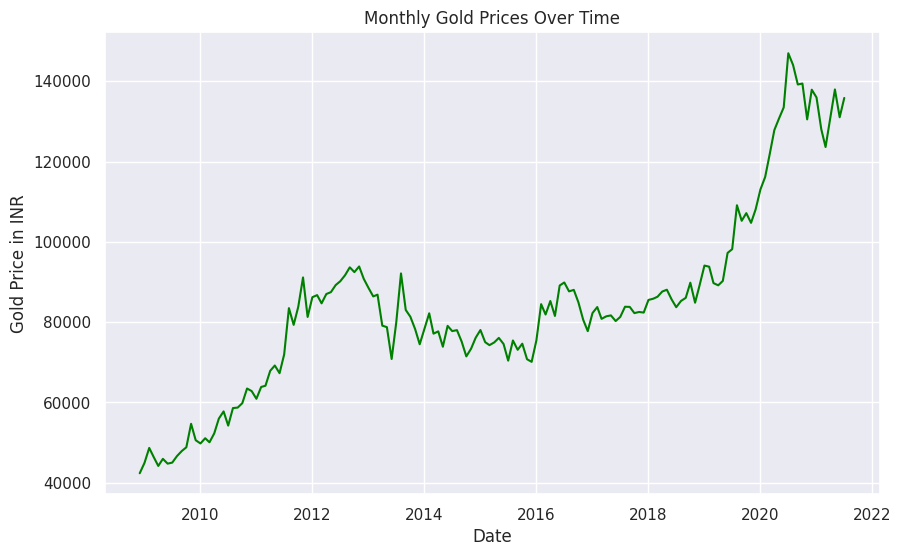

In [10]:
#Let's Visualise the Dataset
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y='India(INR)', data=df, color='green')
plt.title('Monthly Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Gold Price in INR')
plt.show()

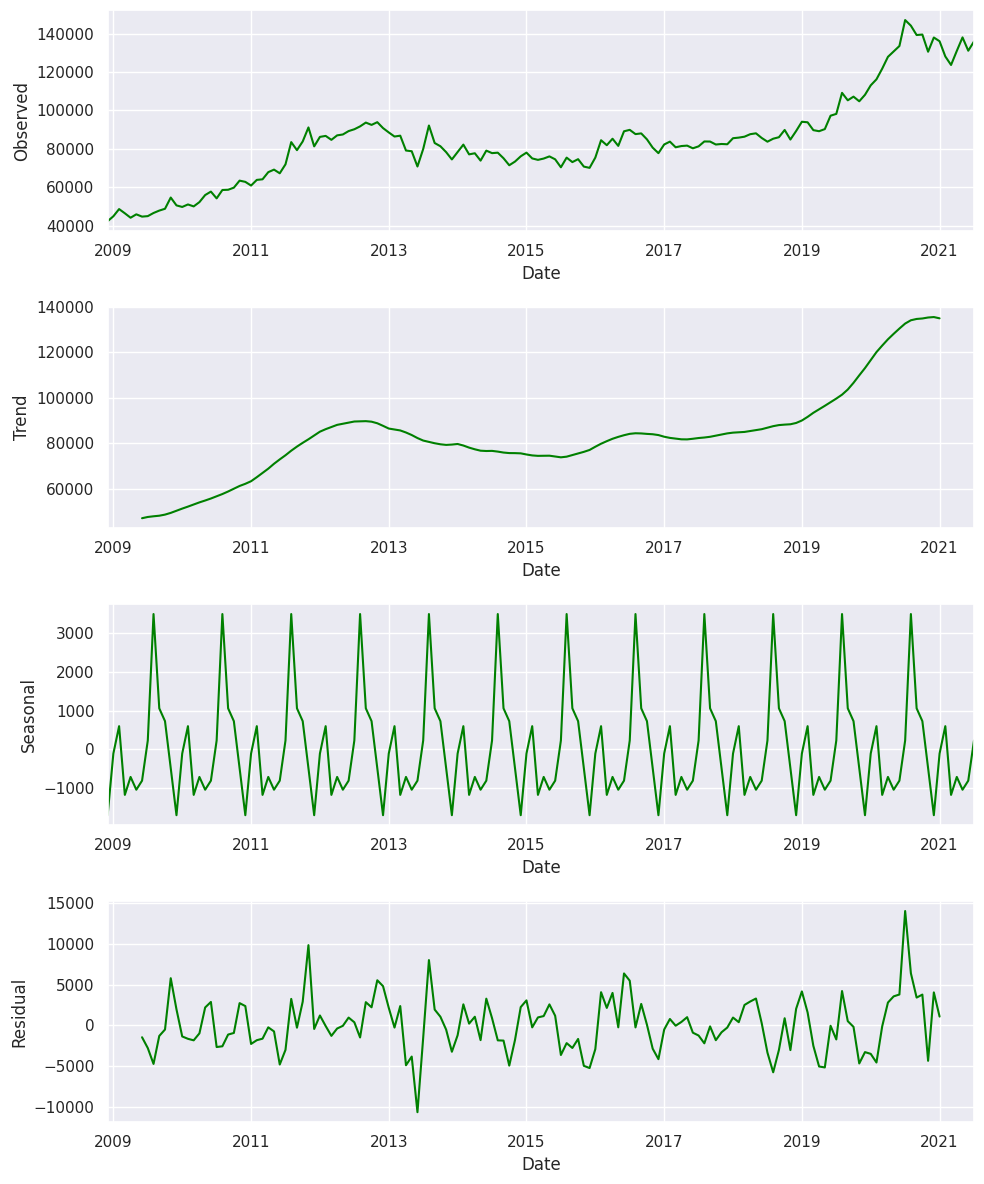

In [11]:
df.set_index("Date", inplace=True)
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['India(INR)'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

result.observed.plot(ax=ax1, color='green')
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color='green')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color='green')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color='green')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

df.reset_index(inplace=True)

In [12]:
df = pd.DataFrame({'unique_id':[1]*len(df),'ds': df["Date"], "y":df['India(INR)']})

In [13]:
train_df = df[df['ds'] <= '31-07-2019']
test_df = df[df['ds'] > '31-07-2019']

# Statistical Forecasting

In [14]:
#install statsforecast
!pip install statsforecast

import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS

# Define the AutoARIMA model
autoarima = AutoARIMA(season_length=12)  # Annual seasonality for monthly data

# Define the AutoETS model
autoets = AutoETS(season_length=12)  # Annual seasonality for monthly data

# Create StatsForecast object with AutoARIMA
statforecast = StatsForecast(df=train_df,
                         models=[autoarima, autoets],
                         freq='MS',
                         n_jobs=-1)

# Fit the model
statforecast.fit()

# Generate forecasts
sf_forecast = statforecast.forecast(h=24)  # Forecasting for 24 periods

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method inst

# ML Forecasting

In [15]:
#install mlforecast
!pip install mlforecast
from mlforecast import MLForecast
from mlforecast.target_transforms import AutoDifferences
from numba import njit
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from mlforecast import MLForecast
from mlforecast.lag_transforms import (
    RollingMean, RollingStd, RollingMin, RollingMax, RollingQuantile,
    SeasonalRollingMean, SeasonalRollingStd, SeasonalRollingMin,
    SeasonalRollingMax, SeasonalRollingQuantile,
    ExpandingMean
)

models = [lgb.LGBMRegressor(verbosity=-1),  # LightGBM regressor with verbosity turned off
    xgb.XGBRegressor(),  # XGBoost regressor with default parameters
    RandomForestRegressor(random_state=0),  # Random Forest regressor with fixed random state for reproducibility
]
fcst = MLForecast(
    models=models,  # List of models to be used for forecasting
    freq='MS',  # Monthly frequency, starting at the beginning of each month
    lags=[1,3,5,7,12],  # Lag features: values from 1, 3, 5, 7, and 12 time steps ago
    lag_transforms={
        1: [  # Transformations applied to lag 1
            RollingMean(window_size=3),  # Rolling mean with a window of 3 time steps
            RollingStd(window_size=3),  # Rolling standard deviation with a window of 3 time steps
            RollingMin(window_size=3),  # Rolling minimum with a window of 3 time steps
            RollingMax(window_size=3),  # Rolling maximum with a window of 3 time steps
            RollingQuantile(p=0.5, window_size=3),  # Rolling median (50th percentile) with a window of 3 time steps
            ExpandingMean()  # Expanding mean (mean of all previous values)
        ],
        6:[  # Transformations applied to lag 6
            RollingMean(window_size=6),  # Rolling mean with a window of 6 time steps
            RollingStd(window_size=6),  # Rolling standard deviation with a window of 6 time steps
            RollingMin(window_size=6),  # Rolling minimum with a window of 6 time steps
            RollingMax(window_size=6),  # Rolling maximum with a window of 6 time steps
            RollingQuantile(p=0.5, window_size=6),  # Rolling median (50th percentile) with a window of 6 time steps
        ],
        12: [  # Transformations applied to lag 12 (likely for yearly seasonality)
            SeasonalRollingMean(season_length=12, window_size=3),  # Seasonal rolling mean with 12-month seasonality and 3-month window
            SeasonalRollingStd(season_length=12, window_size=3),  # Seasonal rolling standard deviation with 12-month seasonality and 3-month window
            SeasonalRollingMin(season_length=12, window_size=3),  # Seasonal rolling minimum with 12-month seasonality and 3-month window
            SeasonalRollingMax(season_length=12, window_size=3),  # Seasonal rolling maximum with 12-month seasonality and 3-month window
            SeasonalRollingQuantile(p=0.5, season_length=12, window_size=3)  # Seasonal rolling median with 12-month seasonality and 3-month window
        ]
    },
    date_features=['year', 'month', 'quarter'],  # Extract year, month, and quarter from the date as features
    target_transforms=[AutoDifferences(max_diffs=3)])


fcst.fit(train_df)
ml_forecast = fcst.predict(len(test_df))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# TimeGPT Zero-shot Forecasting

In [16]:
# !pip install nixtla
# from nixtla import NixtlaClient
# # Get your API Key at dashboard.nixtla.io
# #Instantiate the NixtlaClient
# nixtla_client = NixtlaClient(api_key = 'Your_API_Key')
# #Get the forecast
# timegpt_forecast = nixtla_client.forecast(df = train_df, h=24, freq="M")

# TimesFM Forecasting

In [21]:
!pip install timesfm #You might need to restart the kernal to have this installed in your w
import timesfm
# Initialize the TimesFM model with specified parameters
tfm = timesfm.TimesFm(
    context_len=128,       # Length of the context window for the model
    horizon_len=24,        # Forecasting horizon length
    input_patch_len=32,    # Length of input patches
    output_patch_len=128,  # Length of output patches
    num_layers=20,
    model_dims=1280,
)

# Load the pretrained model checkpoint
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Generate forecasts using the TimesFM model on the given DataFrame
timesfm_forecast = tfm.forecast_on_df(
    inputs=train_df,       # Input DataFrame containing the time-series data for training
    freq="MS",             # Frequency of the time-series data (e.g., monthly start)
    value_name="y",        # Name of the column containing the values to be forecasted
    num_jobs=-1,           # Number of parallel jobs to use for forecasting (-1 uses all available cores)
)
timesfm_forecast = timesfm_forecast[["ds","timesfm"]]

In [22]:
# Assuming the DataFrames have a common column 'ds' for the dates
# Convert 'ds' to datetime in all DataFrames if necessary
sf_forecast['ds'] = pd.to_datetime(sf_forecast['ds'])
ml_forecast['ds'] = pd.to_datetime(ml_forecast['ds'])
# timegpt_forecast['ds'] = pd.to_datetime(timegpt_forecast['ds'])
timesfm_forecast['ds'] = pd.to_datetime(timesfm_forecast['ds'])

# Now perform the merges
merged_fcst = pd.merge(sf_forecast, ml_forecast, on='ds')
# merged_fcst = pd.merge(merged_fcst, timegpt_forecast, on='ds')
merged_fcst = pd.merge(merged_fcst, timesfm_forecast, on='ds')


#Adding the actuals to the dataframe from test_df
merged_fcst = pd.merge(merged_fcst, test_df, on='ds')

#Keep only relevant columns
# merged_fcst = merged_fcst[["unique_id", "ds", "AutoARIMA", "AutoETS", "LGBMRegressor", "XGBRegressor", "RandomForestRegressor", "TimeGPT", "timesfm"]]
merged_fcst = merged_fcst[["unique_id", "ds", "AutoARIMA", "AutoETS", "LGBMRegressor", "XGBRegressor", "RandomForestRegressor", "timesfm"]]

In [23]:
import numpy as np
def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    metrics_dict = {
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df

# Extract 'Weekly_Sales' as actuals
actuals = merged_fcst['y']

error_metrics_dict = {}


for col in merged_fcst.columns[2:-1]:  # Exclude 'Weekly_Sales'
    predicted_values = merged_fcst[col]
    error_metrics_dict[col] = calculate_error_metrics(actuals, predicted_values)['Value'].values  # Extracting 'Value' column


error_metrics_df = pd.DataFrame(error_metrics_dict)
error_metrics_df.insert(0, 'Metric', calculate_error_metrics(actuals, actuals)['Metric'].values)  # Adding 'Metric' column


print(error_metrics_df)